<a href="https://colab.research.google.com/github/adan35/AiDreams/blob/murtaza/EMod_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset_emotions_downsampled.csv')
##df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/emotion_dataset.pkl", compression='infer')

In [ ]:
df.head()

,Unnamed: 0,text,emotions
0,49682,watch feeling heartless aching pick,anger
1,21293,feel like vicious cycle lately dumb things won...,anger
2,31630,get layouts without feeling distracted,anger
3,11616,feel rude trying get point across,anger
4,52234,im feelin rebellious,anger


In [ ]:
df.columns

Index(['Unnamed: 0', 'text', 'emotions'], dtype='object')

In [ ]:
data = df[['text', 'emotions']]
data = data.dropna()
data.head(10000)

,text,emotions
0,watch feeling heartless aching pick,anger
1,feel like vicious cycle lately dumb things won...,anger
2,get layouts without feeling distracted,anger
3,feel rude trying get point across,anger
4,im feelin rebellious,anger
...,...,...
9996,feel cold shamed lying naked floor illusion ne...,anger
9997,hate feeling like im hated,anger
9998,would love happy time performance feelings bit...,anger
9999,wish leave alone try stay away harder tries ni...,anger


In [ ]:
data.shape

(89752, 2)

In [ ]:
data.dtypes

text        object
emotions    object
dtype: object

In [ ]:
data.emotions.value_counts()

fear        14959
joy         14959
love        14959
sadness     14959
surprise    14959
anger       14957
Name: emotions, dtype: int64

In [ ]:
data.emotions.value_counts()

fear        14959
joy         14959
love        14959
sadness     14959
surprise    14959
anger       14957
Name: emotions, dtype: int64

In [ ]:
data.head()

,text,emotions
0,watch feeling heartless aching pick,anger
1,feel like vicious cycle lately dumb things won...,anger
2,get layouts without feeling distracted,anger
3,feel rude trying get point across,anger
4,im feelin rebellious,anger


In [ ]:
def example_complain(index):
  example = data[data.index == index][['text','emotions']].values[0]
  if len(example)>0:
    print(example[0])
    print()
    print('Category:',example[1])
    

In [ ]:
example_complain(10)

feel rude towards

Category: anger


In [ ]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['text'] = data['text'].apply(clean_text)

In [ ]:
example_complain(10)

feel rude towards

Category: anger


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34421 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (89752, 250)


In [ ]:
X

array([[   0,    0,    0, ..., 1035, 2824,  424],
       [   0,    0,    0, ...,  114,    1,  359],
       [   0,    0,    0, ..., 5028, 3324, 1377],
       ...,
       [   0,    0,    0, ...,    1,   81,  491],
       [   0,    0,    0, ...,    8,   31, 1294],
       [   0,    0,    0, ...,    1,  937,  374]], dtype=int32)

In [ ]:
Y = pd.get_dummies(data['emotions']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (89752, 6)


In [ ]:
Y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(80776, 250) (80776, 6)
(8976, 250) (8976, 6)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1136/1136 [==============================] - 892s 782ms/step - loss: 0.4604 - accuracy: 0.8396 - val_loss: 0.1442 - val_accuracy: 0.9465
Epoch 2/5
1136/1136 [==============================] - 872s 768ms/step - loss: 0.1326 - accuracy: 0.9484 - val_loss: 0.1299 - val_accuracy: 0.9496
Epoch 3/5
1136/1136 [==============================] - 868s 764ms/step - loss: 0.1045 - accuracy: 0.9558 - val_loss: 0.1321 - val_accuracy: 0.9459
Epoch 4/5
1136/1136 [==============================] - 867s 763ms/step - loss: 0.0917 - accuracy: 0.9597 - val_loss: 0.1441 - val_accuracy: 0.9453
Epoch 5/5
1136/1136 [==============================] - 868s 764ms/step - loss: 0.0816 - accuracy: 0.9642 - val_loss: 0.1501 - val_accuracy: 0.9426


In [ ]:
import keras
model.save("/content/drive/My Drive/Colab Notebooks/EMod_1")
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EMod_1')

In [ ]:
import keras
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EMod_1/')

OSError: ignored

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

281/281 [==============================] - 23s 81ms/step - loss: 0.1621 - accuracy: 0.9395
Test set
  Loss: 0.162
  Accuracy: 0.940


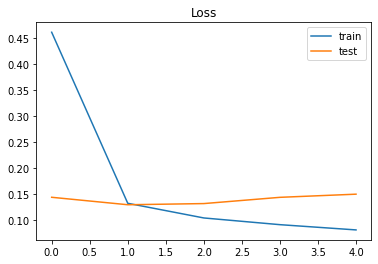

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

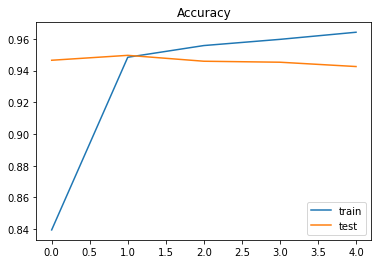

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['watch feeling heartless aching pick']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['fear', 'joy', 'love', 'sadness', 'surprise', 'anger']

print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 49ms/step
[[9.9972409e-01 2.6486459e-05 2.0444655e-07 2.8664240e-07 2.4766728e-04
  1.2810208e-06]] fear
